# Targeted poisoning attack on MNIST dataset

## Import Libraries

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_federated as tff
from matplotlib import pyplot as plt
import collections

tf.get_logger().setLevel('ERROR')

import random
from tqdm import tqdm
import copy

2023-06-09 15:19:27.003885: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-09 15:19:27.634314: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Parameters declaration

In [2]:
n_clients = 100
n_test_clients = 100

n_train_dataset_epochs = 6
n_test_dataset_epochs = 3
n_train_epochs = 50
batch_size_train = 20
batch_size_test = 4

client_learning_rate = 0.02
server_learning_rate = 1.5


hidden_units = 256
dropout = 0.1

mal_users_percentage = 0.2
# todo: could also be a list of values
target_value = 3
poisoned_value = 8



## Dataset Loading and manipulation

In [3]:
emnist_train, emnist_test = tff.simulation.datasets.emnist.load_data()

2023-06-09 15:19:31.434287: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10362 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1
2023-06-09 15:19:31.434761: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 11390 MB memory:  -> device: 1, name: NVIDIA TITAN X (Pascal), pci bus id: 0000:02:00.0, compute capability: 6.1


In [4]:
example_dataset = emnist_train.create_tf_dataset_for_client(
    emnist_train.client_ids[45])

test_dataset = emnist_test.create_tf_dataset_for_client(
    emnist_train.client_ids[45])

print(emnist_train.client_ids[0:10])
print(emnist_test.client_ids[0:10])
cnt_train = 0
cnt_test = 0

for item in example_dataset:
    cnt_train += 1 

for item in test_dataset:
    cnt_test += 1


print(cnt_train)
print(cnt_test)

['f0000_14', 'f0001_41', 'f0005_26', 'f0006_12', 'f0008_45', 'f0011_13', 'f0014_19', 'f0016_39', 'f0017_07', 'f0022_10']
['f0000_14', 'f0001_41', 'f0005_26', 'f0006_12', 'f0008_45', 'f0011_13', 'f0014_19', 'f0016_39', 'f0017_07', 'f0022_10']
93
11


### Preprocessing and organizing dataset

In [5]:
shuffle_buffer = 100
# todo change??
prefetch_buffer = 10

In [6]:
def batch_format(element):
    # flatten the images
    return collections.OrderedDict(
        x = tf.reshape(element['pixels'], [-1, 28, 28]),
        y = tf.reshape(element['label'], [-1, 1]))

def preprocess(dataset, train):
    if train == True:
        dataset = dataset.repeat(n_train_dataset_epochs)
    else:
        dataset = dataset.repeat(n_test_dataset_epochs)
        
    dataset = dataset.shuffle(shuffle_buffer, seed = 1)
    if train == True:
        dataset = dataset.batch(batch_size_train)
    else: 
        dataset = dataset.batch(batch_size_test)
        
    dataset = dataset.map(batch_format)
    dataset = dataset.prefetch(prefetch_buffer)

    return dataset

In [7]:
def poison_dataset(dataset, target_honest, target_mal):
    # parse the dataset
    for batch in dataset:
        # get the labels of each batch and convert to numpy array
        labels = batch['y'].numpy()
        # itterate through each label
        for y in labels:
            # if we find the target label	
            if y == target_honest:
                y = target_mal
        batch['y'] = tf.convert_to_tensor(labels, dtype = tf.float32)
    # return the malicious dataset
    return dataset

In [8]:
## testing the preprocessing function

example_dataset = emnist_train.create_tf_dataset_for_client(
    emnist_train.client_ids[0])
     
preprocessed_example_dataset = preprocess(example_dataset, True)

In [9]:
def make_federated_data(client_data, client_ids, train):

    fed_data = []
    for id in client_ids:
        preprocessed_dataset = preprocess(client_data.create_tf_dataset_for_client(id), train)
        # prob = random.random()
        # mal% of the users are malicious
        # if prob < mal_users_percentage:  
        #     preprocessed_dataset = poison_dataset(preprocessed_dataset, target_honest, target_mal)              

        fed_data.append(preprocessed_dataset)

    return fed_data

## Model creation

In [10]:

def create_model():
      return tf.keras.models.Sequential([
      tf.keras.layers.Reshape(input_shape=(28,28,1), target_shape=(28,28,1)),
      tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dropout(dropout),
      tf.keras.layers.Dense(10, activation='softmax')
  ])

In [11]:
def mnist_model():
    keras_model = create_model()
    return tff.learning.models.from_keras_model(
        keras_model,
        input_spec = preprocessed_example_dataset.element_spec,
        loss = tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics = [tf.keras.metrics.SparseCategoricalAccuracy()])
        

## Training

In [12]:
training_process = tff.learning.algorithms.build_unweighted_fed_avg(
    mnist_model,
    client_optimizer_fn = lambda: tf.keras.optimizers.SGD(learning_rate = client_learning_rate),
    server_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate = server_learning_rate))

2023-06-09 15:19:34.419999: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'batch_input' with dtype float and shape [?,28,28]
	 [[{{node batch_input}}]]
2023-06-09 15:19:34.713546: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'args_1' with dtype float and shape [?,28,28]
	 [[{{node args_1}}]]
2023-06-09 15:19:34.713624: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'args_2' with dtype int32 and shape [?,1]
	 [[{{node args_2}}]]
2023

In [13]:
train_state = training_process.initialize()


2023-06-09 15:19:35.951089: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 2
2023-06-09 15:19:35.951220: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-06-09 15:19:35.953616: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10362 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1
2023-06-09 15:19:35.953865: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 11390 MB memory:  -> device: 1, name: NVIDIA TITAN X (Pascal), pci bus id: 0000:02:00.0, compute capability: 6.1
2023-06-09 15:19:35.987519: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 2
2023-06-09 15:19:35.987596: I tensorflow/core/grappler/clusters/single_machine.

In [14]:
# build the process to have the model's architecture
evaluation_process = tff.learning.algorithms.build_fed_eval(mnist_model)

# initialize the state of the evaluation
evaluation_state = evaluation_process.initialize()
sample_test_clients = emnist_test.client_ids[0:n_test_clients]


# step = 16
# sample_test_clients = [emnist_train.client_ids[x] for x in range (0, n_clients * step, step)]

# test the model with the test data
# question: selection of clients during training??
federated_test_data = make_federated_data(emnist_test, sample_test_clients, train=False)

2023-06-09 15:19:42.167497: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'batch_input' with dtype float and shape [?,28,28]
	 [[{{node batch_input}}]]
2023-06-09 15:19:42.257136: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'args_1' with dtype float and shape [?,28,28]
	 [[{{node args_1}}]]
2023-06-09 15:19:42.257210: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'args_2' with dtype int32 and shape [?,1]
	 [[{{node args_2}}]]
2023

In [15]:
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

training_loss = []
training_acc = []
eval_loss = []
eval_acc = []

clients = emnist_train.client_ids[0:n_clients]
step = 16
clients = [emnist_train.client_ids[x] for x in range (0, n_clients * step, step)]

#note: slow to converge with random clients, makes sense

for epoch in range(1, n_train_epochs):

    print('Epoch: {:2d}'.format(epoch))
    # client selection, random, chosen from the first 100 clients
    clients = random.sample(emnist_train.client_ids, n_clients)

    federated_train_data = make_federated_data(emnist_train, clients, train=True)
    federated_test_data = make_federated_data(emnist_test, sample_test_clients, train=False)
    
    
    # run a next on the training process to train the model
    result = training_process.next(train_state, federated_train_data)
    # update the model's state and get access to the metrics
    train_state = result.state
    train_metrics = result.metrics
    # print the training metrics
    training_acc.append(train_metrics['client_work']['train']['sparse_categorical_accuracy'])
    training_loss.append(train_metrics['client_work']['train']['loss'])

    print('Training accuracy: {:.3f}, Training loss: {:.3f}'.format(training_acc[-1], training_loss[-1]))

    # evaluate the model with test data

    # get weights from the trainged model
    model_weights = training_process.get_model_weights(train_state)
    # update the evaluation state with them
    evaluation_state = evaluation_process.set_model_weights(evaluation_state, model_weights)
    # run a next() to evaluate the model
    evaluation_output = evaluation_process.next(evaluation_state, federated_test_data)

    # get access to the evaluation metrics
    eval_metrics = evaluation_output.metrics['client_work']['eval']['total_rounds_metrics']

    eval_acc.append(eval_metrics['sparse_categorical_accuracy'])
    eval_loss.append(eval_metrics['loss'])
    # print the training metrics
    print('Testing accuracy: {:.3f}, Testing loss: {:.3f}\n\n'.format(eval_acc[-1], eval_loss[-1]))

Epoch:  1


2023-06-09 15:19:48.129704: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 2
2023-06-09 15:19:48.129794: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-06-09 15:19:48.131378: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10362 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1
2023-06-09 15:19:48.131546: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 11390 MB memory:  -> device: 1, name: NVIDIA TITAN X (Pascal), pci bus id: 0000:02:00.0, compute capability: 6.1
2023-06-09 15:19:48.228161: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 2
2023-06-09 15:19:48.228231: I tensorflow/core/grappler/clusters/single_machine.

Training accuracy: 0.120, Training loss: 2.306


2023-06-09 15:19:53.723685: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 2
2023-06-09 15:19:53.723762: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-06-09 15:19:53.725911: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10362 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1
2023-06-09 15:19:53.726217: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 11390 MB memory:  -> device: 1, name: NVIDIA TITAN X (Pascal), pci bus id: 0000:02:00.0, compute capability: 6.1
2023-06-09 15:19:53.747825: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 2
2023-06-09 15:19:53.747891: I tensorflow/core/grappler/clusters/single_machine.

Testing accuracy: 0.182, Testing loss: 2.276


Epoch:  2
Training accuracy: 0.218, Training loss: 2.245
Testing accuracy: 0.437, Testing loss: 2.230


Epoch:  3
Training accuracy: 0.350, Training loss: 2.198
Testing accuracy: 0.534, Testing loss: 2.177


Epoch:  4
Training accuracy: 0.430, Training loss: 2.134
Testing accuracy: 0.556, Testing loss: 2.102


Epoch:  5
Training accuracy: 0.543, Training loss: 2.037
Testing accuracy: 0.609, Testing loss: 1.996


Epoch:  6
Training accuracy: 0.585, Training loss: 1.932
Testing accuracy: 0.650, Testing loss: 1.862


Epoch:  7
Training accuracy: 0.657, Training loss: 1.758
Testing accuracy: 0.660, Testing loss: 1.698


Epoch:  8
Training accuracy: 0.704, Training loss: 1.585
Testing accuracy: 0.701, Testing loss: 1.518


Epoch:  9
Training accuracy: 0.756, Training loss: 1.381
Testing accuracy: 0.713, Testing loss: 1.340


Epoch: 10
Training accuracy: 0.796, Training loss: 1.184
Testing accuracy: 0.735, Testing loss: 1.181


Epoch: 11
Trainin

In [16]:
emnist_train
# clients = emnist_train.client_ids[0:n_clients]
# print(clients)

In [17]:
print(evaluation_output.metrics)

OrderedDict([('distributor', ()), ('client_work', OrderedDict([('eval', OrderedDict([('current_round_metrics', OrderedDict([('sparse_categorical_accuracy', 0.9029982), ('loss', 0.3228701), ('num_examples', 3402), ('num_batches', 883)])), ('total_rounds_metrics', OrderedDict([('sparse_categorical_accuracy', 0.9029982), ('loss', 0.3228701), ('num_examples', 3402), ('num_batches', 883)]))]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', ())])


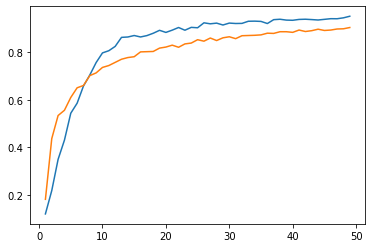

In [18]:
epochs = [x for x in range(1, n_train_epochs)]
plt.plot(epochs, training_acc)
plt.plot(epochs, eval_acc)
plt.show()

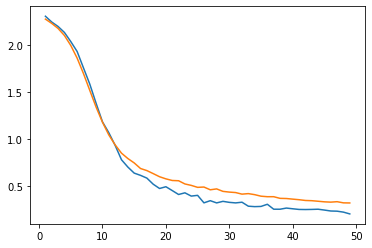

In [19]:
epochs = [x for x in range(1, n_train_epochs)]
plt.plot(epochs, training_loss)
plt.plot(epochs, eval_loss)
plt.show()